In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import metrics
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom, Reshape, Concatenate, RandomContrast, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Read data

In [2]:
# Load data
data = pd.read_csv("./Flipkart/flipkart_com-ecommerce_sample_1050.csv")

# Create categories and labels

In [3]:
data['category'] = data['product_category_tree'].str.replace(r'^\["', '', regex=True).str.split(' >> ').str[0]

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data["category"])
data["label"] = le.transform(data["category"])

In [5]:
data[['category', 'label', 'image']]

,category,label,image
0,Home Furnishing,4,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,0,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,0,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,4,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,4,6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...,...
1045,Baby Care,0,958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,Baby Care,0,fd6cbcc22efb6b761bd564c28928483c.jpg
1047,Baby Care,0,5912e037d12774bb73a2048f35a00009.jpg
1048,Baby Care,0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


In [6]:
data[['category', 'label']].groupby("category").count()

,label
category,
Baby Care,150
Beauty and Personal Care,150
Computers,150
Home Decor & Festive Needs,150
Home Furnishing,150
Kitchen & Dining,150
Watches,150


# Separate data into train and test sets

In [7]:
from sklearn.model_selection import train_test_split

# Initialize empty dataframes for train and test
data_train = pd.DataFrame(columns=['label', 'image'])
data_test = pd.DataFrame(columns=['label', 'image'])

# For each category
for label in data['label'].unique():
    # Get all rows for this category
    category_data = data[data['label'] == label]

    # Split the category data into train and test
    train, test = train_test_split(category_data, test_size=0.2)

    # Concatenate the train and test data to the respective dataframes
    data_train = pd.concat([data_train, train])
    data_test = pd.concat([data_test, test])

# Reset the index of the dataframes
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [8]:
num_categories = len(data['label'].unique())
IMG_SIZE = 224

# Approche 1 : Préparation initiale des images

Avec ImageNet, VGG16 a été [entraîné sur des images](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) de montres, d'ordinateurs, de meubles, mais pas vraiment de cuisine, décoration, baby care et beauté.  
Il faudra peut-être réentraîner les dernières couches du CNN en plus du classifieur.

In [9]:
def create_model_fct(num_categories) :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x) # Passe de 3D (largeur, hauteur, couleurs) à 1D, nécessaire pour les couches fully connected suivantes
    x = Dense(256, activation='relu')(x) # Intermédiaire de 256 labels pour le passage de 1000 labels (ImageNet) à 7 labels (Mes données) -> Permet de ne pas perdre trop d'informations d'un coup
    x = Dropout(0.5)(x) # Désactive aléatoirement 50% des neurones à chaque epoch pendant l'entraînement. Aide à prévenir le surapprentissage et à généraliser le modèle.
    predictions = Dense(num_categories, activation='softmax')(x) # Convertit les sorties en probabilités (somme à 1) pour chacune de mes 7 classes.

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    
    loss = "categorical_crossentropy" # Mieux quand plus que 2 labels, mais sensible aux quantités de labels déséquilibrées (pas le cas ici)
    # Alternatives :
    # a) Sparse Categorical Crossentropy : Utile quand les étiquettes sont des entiers plutôt que des one-hot encodées
    # b) Binary Crossentropy :  Pour la classification binaire
    # c) Focal Loss : Pour les datasets très déséquilibrés
    
    optimizer = 'rmsprop' # Bonne performance sur de nombreux problèmes, mais peut nécessiter un réglage fin du taux d'apprentissage initial
    # Alternatives :
    # a) SGD (Stochastic Gradient Descent) avec momentum : donner de meilleures performances de généralisation quand on a le temps de bien ajuster les hyperparamètres
    # b) Adam : Combine les avantages de RMSprop et de SGD, souvent considéré comme un bon choix par défaut
    # c) Adagrad : Bon pour les problèmes avec des features rares (problèmes de NLP)
    
    model_metrics = [
        "accuracy", # Mesure la proportion de prédictions correctes, mais peut être trompeuse pour les datasets déséquilibrés
        # "f1-score", # Équilibre entre précision et rappel (= taux de vrais-positifs). Utile pour les datasets déséquilibrés
        # "auc-roc", # Insensible au déséquilibre des classes en classification binaire. 1 = parfait, 0.5 = pas mieux que le hasard
        # "Precision-Recall", # Donnent plus d'informations sur les types d'erreurs que fait le modèle, quand les faux positifs ou faux négatifs ont des coûts différents
    ] 
    
    model.compile(loss=loss, optimizer=optimizer, metrics=model_metrics)

    print(model.summary())
    
    return model

In [10]:
def image_prep_fct(df) :
    prepared_images = []
    for image_num in range(len(df['image'])) :
        img_path = os.path.join('./Flipkart/Images', df['image'][image_num])
        img = (load_img(
            img_path,
            target_size=(IMG_SIZE, IMG_SIZE)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data_train)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(840, 224, 224, 3)


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [11]:
X = images_np
y = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [13]:
model1_save_path1 = "./model1_best_weights.keras"

In [14]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct(num_categories)

# Création du callback
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [24]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3389 - loss: 7.7905
Epoch 1: val_loss improved from inf to 1.58566, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 126s 13s/step - accuracy: 0.3468 - loss: 7.5989 - val_accuracy: 0.7476 - val_loss: 1.5857
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6852 - loss: 2.4128 
Epoch 2: val_loss improved from 1.58566 to 1.21917, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 136s 14s/step - accuracy: 0.6847 - loss: 2.4054 - val_accuracy: 0.7857 - val_loss: 1.2192
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7700 - loss: 1.1136
Epoch 3: val_loss improved from 1.21917 to 1.17539, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 126s 13s/step - accuracy: 0.7691 - loss: 1.1218 - val_accuracy: 0.7810 - val_loss: 1.1754
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7921 - loss: 0.9690 
Epoch 4: val_loss improved fro

In [53]:
import pickle

# Save the trained model and history variables to a file
with open('1-model_history.pkl', 'wb') as f:
    pickle.dump((model1, history1), f)

In [27]:
import pickle

# Load the trained model and history variables from the file
with open('1-model_history.pkl', 'rb') as f:
    model1, history1 = pickle.load(f)

In [28]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_test, y_test, verbose=True)
print("Test Accuracy       :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.8594 - loss: 0.6444
Training Accuracy: 0.8873

7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9186 - loss: 0.3918
Validation Accuracy:  0.9238

7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9074 - loss: 0.4128
Test Accuracy       :  0.8905


In [29]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Training Accuracy: 0.8873
Validation Accuracy :  0.9238
Test Accuracy       :  0.8905


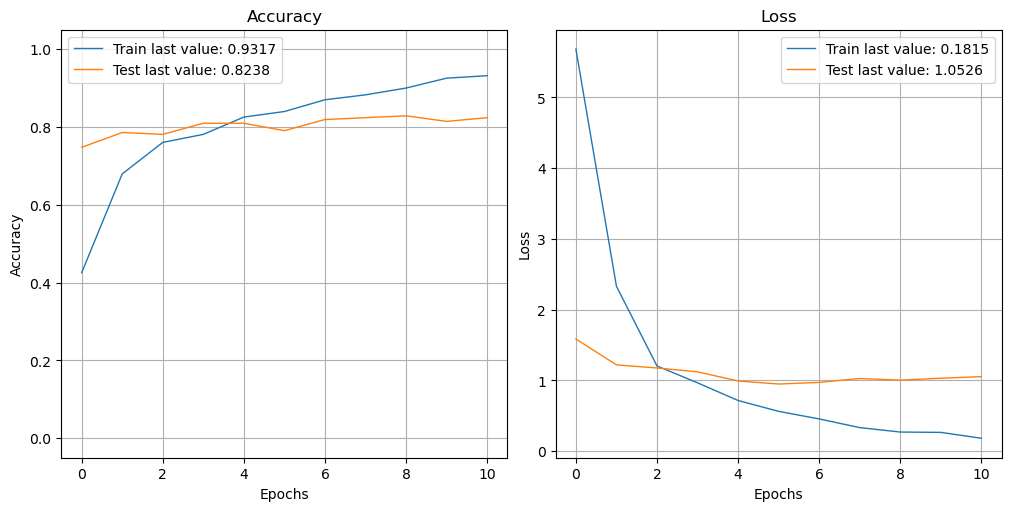

In [27]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [28]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[0 2 6 2 4 1 6 0 3 0 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 4 2 4 3 3 4 5 6 5 2
 0 6 3 0 5 6 5 4 0 0 6 4 6 5 0 3 3 5 3 5 4 4 4 0 0 6 6 2 1 0 3 1 2 4 3 5 1
 4 6 0 4 5 1 4 0 0 0 3 3 2 2 4 1 3 5 4 3 5 4 6 0 2 3 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 0 0 0 5 2 6 3 6 0 1 2 6 6 2 1 5 3 4 3 0 5 3 0 0 0 0
 5 0 0 6 0 0 4 4 2 4 1 2 4 0 5 3 4 1 5 2 4 1 0 2 1 5 4 2 4 5 0 0 6 3 0 4 6
 3 0 2 3 1 1 0 6 1 0 0 5 4 2 3 1 6 1 3 1 5 6 3 6 5]


In [30]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[25  0  0  2  3  0  0]
 [ 1 24  1  2  1  0  1]
 [ 1  0 22  4  1  2  0]
 [ 3  0  1 22  1  3  0]
 [ 5  0  0  0 25  0  0]
 [ 5  1  0  2  1 21  0]
 [ 0  1  0  1  0  1 27]]


In [32]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [33]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[25  0  0  2  3  0  0]
 [ 1 24  1  2  1  0  1]
 [ 1  0 22  4  1  2  0]
 [ 3  0  1 22  1  3  0]
 [ 5  0  0  0 25  0  0]
 [ 5  1  0  2  1 21  0]
 [ 0  1  0  1  0  1 27]]

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        30
           1       0.92      0.80      0.86        30
           2       0.92      0.73      0.81        30
           3       0.67      0.73      0.70        30
           4       0.78      0.83      0.81        30
           5       0.78      0.70      0.74        30
           6       0.96      0.90      0.93        30

    accuracy                           0.79       210
   macro avg       0.81      0.79      0.79       210
weighted avg       0.81      0.79      0.79       210



<Axes: >

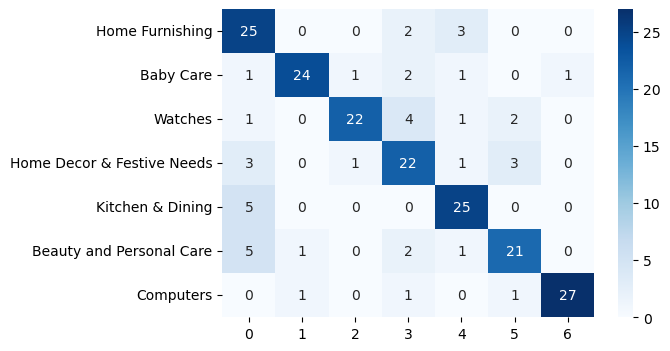

In [35]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data['category'].unique().tolist()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Approche 2 : ImageDatagenerator avec data augmentation
1. __Création de variations :__ Le générateur de données va effectivement créer des variations des images originales à la volée pendant l'entraînement. Ces variations peuvent inclure :
- zooms
- rotations
- changements d'angle
- décalages horizontaux ou verticaux
- retournements horizontaux ou verticaux
- changements de luminosité ou de contraste

2. __Entraînement sur les variations :__ Le modèle est ensuite entraîné sur ces images modifiées, en plus des images originales.  


3. __Amélioration de la généralisation :__ L'objectif principal est d'améliorer la capacité du modèle à généraliser. En exposant le modèle à ces variations, on lui apprend à reconnaître les caractéristiques importantes des classes, même lorsque les images sont prises dans des conditions légèrement différentes.  


4. __Augmentation virtuelle du jeu de données :__ Cette technique permet d'augmenter virtuellement la taille du jeu de données d'entraînement sans avoir besoin de collecter réellement plus d'images.

In [19]:
model2_save_path = "./model2_best_weights.keras"

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
# Pour mélanger les images, classées initalement par classe
data_train = data_train.sample(frac=1, random_state=18).reset_index(drop=True)

In [22]:
batch_size = 32 # Nombre d'images traîtées à la fois pendant l'entraînement, plus efficace en terme de mémoire que de toutes les charger d'un coup, mais plus rapide que de les faire une par une

def data_flow_fct(data, datagen, data_type=None) : # data_type=None : ne sépare pas le jeu de données en entraînement et test (car déjà fait plus haut)
    data_flow = datagen.flow_from_dataframe(
        data, 
        directory='./Flipkart/Images',
        x_col='image', y_col='category',
        weight_col=None, # Pondération des échantillons du jeu de donnée, pour donner plus d'importance à des labels moins représentés ou plus difficiles. Ici, pas besoin car distribution des échantillons homogène
        target_size=(IMG_SIZE, IMG_SIZE),
        classes=None, # Fait automatiquement le mapping entre labels (int) et catégories (str)
        class_mode='categorical', # Précise le type de classe (ici catégoriel) pour les enconder si besoin (ici en one-hot)
        batch_size=batch_size, # Nombre d'images traîtées à la fois pendant l'entraînement
        shuffle=True, # Mélange les données à chaque époque
        seed=18,
        subset=data_type # Permet de préciser si c'est le jeu de données d'entraînement ou de validation
    )
    return data_flow

In [23]:
# Créer des objets qui vont, à partir des images d'entraînement, générer des images un peu différentes

datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20, # Rotation aléatoire jusqu'à 20 degrés
    width_shift_range=0.2, # Décalage horizontal aléatoire jusqu'à 20% de la largeur
    height_shift_range=0.2, # Décalage vertical aléatoire jusqu'à 20% de la hauteur
    horizontal_flip=True, # Retournement horizontal aléatoire
    validation_split=0.25, 
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data_train, datagen_train, data_type='training')
val_flow = data_flow_fct(data_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [50]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct(num_categories)

# Création du callback
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [52]:
# with tf.device('/gpu:0'): 
#     history2 = model2.fit(train_flow,
#                     validation_data=val_flow,
#                     batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3757 - loss: 5.9559
Epoch 1: val_loss improved from inf to 1.30490, saving model to ./model2_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 8s/step - accuracy: 0.3809 - loss: 5.8745 - val_accuracy: 0.7000 - val_loss: 1.3049
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6888 - loss: 1.7406
Epoch 2: val_loss improved from 1.30490 to 1.25488, saving model to ./model2_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.6879 - loss: 1.7407 - val_accuracy: 0.7190 - val_loss: 1.2549
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7022 - loss: 1.3154
Epoch 3: val_loss improved from 1.25488 to 1.10656, saving model to ./model2_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.7019 - loss: 1.3162 - val_accuracy: 0.7571 - val_loss: 1.1066
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7552 - loss: 1.0160
Epoch 4: val_loss did not improve from 1.10656


In [54]:
# import pickle

# # Save the trained model and history variables to a file
# with open('2-model_history.pkl', 'wb') as f:
#     pickle.dump((model2, history2), f)

In [30]:
import pickle

# Load the trained model and history variables from the file
with open('2-model_history.pkl', 'rb') as f:
    model2, history2 = pickle.load(f)

In [31]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(test_flow, verbose=True)
print("Test Accuracy       :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step - accuracy: 0.8970 - loss: 0.5022
Training Accuracy   : 0.9032

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8658 - loss: 0.6955
Validation Accuracy :  0.8905

7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9183 - loss: 0.4209
Test Accuracy       :  0.9095


In [32]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(train_flow, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Training Accuracy   : 0.8857
Validation Accuracy :  0.8952
Test Accuracy       :  0.8905


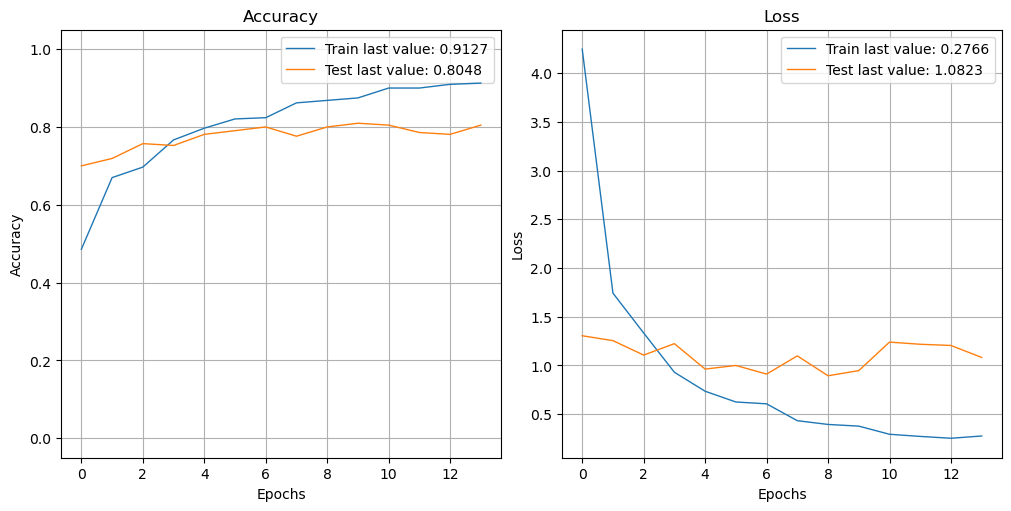

In [57]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="2-standard.png")
plt.close()

# Approche 3 : Nouvelle par Dataset sans data augmentation
Permet de réaliser les calculs plus vite pour les gros jeux de données  
Permet facilement d'ajouter des étapes de prétraitement, de mélange, et de batching directement dans le pipeline de données  
Prétraitement des images une par une à la volée, plutôt que toute en avance  
Code plus maintenable

In [16]:
batch_size = 32

def dataset_fct(data, validation_split=0, data_type=None) :
    # Create a DataFrame from data
    df = pd.DataFrame(data)
    
    # Define the full path of each image
    df['image'] = './Flipkart/Images/' + df['image']

    # Convert labels to one-hot arrays
    num_classes = len(df['label'].unique())
    labels = tf.keras.utils.to_categorical(df['label'].values, num_classes=num_classes)
    
    # Split the data into training and validation sets if validation_split is provided
    if validation_split > 0 and data_type in ['training', 'validation']:
        # Use stratified sampling to maintain the label distribution
        train_df, val_df = train_test_split(df, test_size=validation_split, stratify=df['label'], random_state=42)
        if data_type == 'training':
            df = train_df
            labels = tf.keras.utils.to_categorical(train_df['label'].values, num_classes=num_classes)
        else:
            df = val_df
            labels = tf.keras.utils.to_categorical(val_df['label'].values, num_classes=num_classes)


    # Create tensors from 'image' and 'label' columns
    image_paths = df['image'].values

    # Create a dataset from the tensors
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Load and preprocess the images
    def load_and_preprocess_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image /= 255.0  # Normalize pixel values between 0 and 1
        return image, label

    dataset = dataset.map(load_and_preprocess_image)

    # Shuffle and batch the data
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.batch(batch_size)    

    return dataset, labels, image_paths

In [17]:
# Créer le jeu de données d'entraînement
dataset_train, train_labels, train_filepaths = dataset_fct(data_train, validation_split=0.25, data_type='training')

# Créer le jeu de données de validation
dataset_val, val_labels, val_filepaths = dataset_fct(data_train, validation_split=0.25, data_type='validation')

# Créer le jeu de données de test
dataset_test, test_labels, test_filepaths = dataset_fct(data_test, validation_split=0, data_type=None)

In [98]:
model3_save_path = "./model3_best_weights.keras"

In [99]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct(num_categories)

# Création du callback
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [100]:
# with tf.device('/gpu:0'): 
#     history3 = model3.fit(dataset_train,
#                     validation_data=dataset_val,
#                     batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2575 - loss: 1.9684
Epoch 1: val_loss improved from inf to 1.37729, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.2613 - loss: 1.9587 - val_accuracy: 0.5714 - val_loss: 1.3773
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5305 - loss: 1.3588
Epoch 2: val_loss improved from 1.37729 to 1.15017, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.5323 - loss: 1.3559 - val_accuracy: 0.6524 - val_loss: 1.1502
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6721 - loss: 1.0888
Epoch 3: val_loss improved from 1.15017 to 1.01686, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.6722 - loss: 1.0885 - val_accuracy: 0.6810 - val_loss: 1.0169
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7036 - loss: 0.9483
Epoch 4: val_loss improved from 1.01

In [101]:
# import pickle

# # Save the trained model and history variables to a file
# with open('3-model_history.pkl', 'wb') as f:
#     pickle.dump((model3, history3), f)

In [49]:
import pickle

# Load the trained model and history variables from the file
with open('3-model_history.pkl', 'rb') as f:
    model3, history3 = pickle.load(f)

In [102]:
# Score du dernier epoch

# Indique à quel point le modèle a bien appris les données d'entraînement. Une précision élevée peut indiquer un surapprentissage si la précision sur les données de validation et de test est beaucoup plus faible
loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))

# Indique la capacité du modèle à généraliser à des données non vues pendant l'entraînement. Une précision élevée sur les données de validation est un bon signe de généralisation.
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

# Indique la performance finale du modèle sur des données complètement nouvelles. Une précision élevée sur les données de test est le but ultime, car elle montre que le modèle peut bien généraliser.
print()
loss, accuracy = model3.evaluate(dataset_test, verbose=True)
print("Test Accuracy       :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.8936 - loss: 0.3636
Training Accuracy   : 0.8921

7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.8120 - loss: 0.5862
Validation Accuracy :  0.7762

7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.7669 - loss: 0.7468
Test Accuracy       :  0.7524


In [103]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_train, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Training Accuracy   : 0.8778
Validation Accuracy :  0.7714
Test Accuracy       :  0.7476


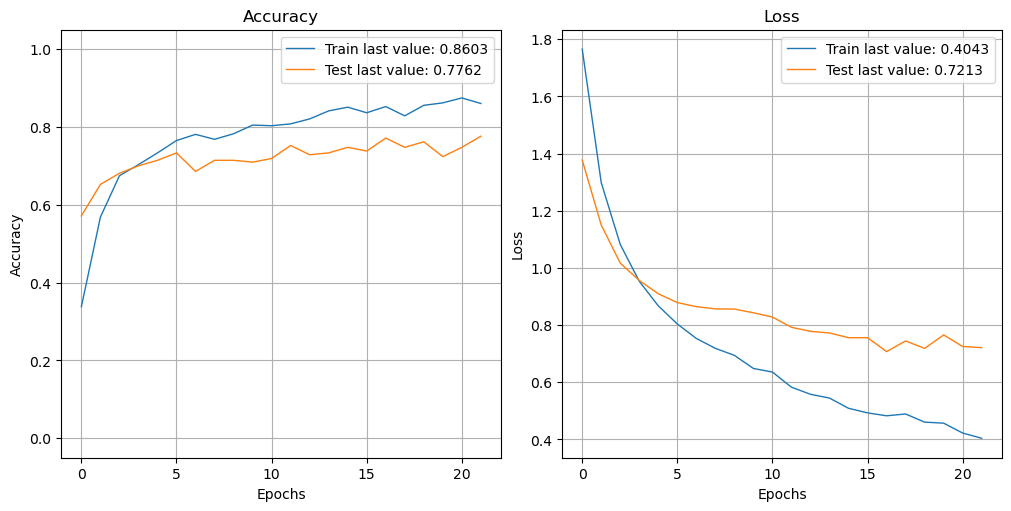

In [104]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="3-standard.png")
plt.close()

In [105]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondence of clusters:", corresp)

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [106]:
def evaluate_model(dataset, model):
    y_true = []
    y_pred = []

    for X_batch, y_batch in dataset:
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
        y_pred.extend(np.argmax(model.predict(X_batch), axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred

In [107]:
# Evaluate the model on the test dataset
y_test_true, y_test_pred = evaluate_model(dataset_test, model3)

# Print the true and predicted labels
print("True labels:")
print(y_test_true)
print("Predicted labels:")
print(y_test_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
True labels:
[4 3 3 6 4 2 6 3 5 5 1 6 2 0 1 1 2 1 5 3 3 4 3 2 2 5 4 1 0 0 3 1 4 0 0 6 4
 6 2 4 5 1 0 1 1 5 1 2 3 3 6 2 3 1 4 2 2 1 6 3 5 1 5 3 3 6 3 5 1 0 4 0 4 1
 6 4 0 0 4 0 4 1 0 1 6 0 2 3 2 6 0 1 6 6 5 3 4 2 2 3 4 4 4 1 6 4 0 1 1 3 2
 1 5 5 6 5 5 6 0 2 2 3 6 1 5 6 0 2 6 3 4 0 2 1 4 3 2 3 2 3 1 0 2 2 4 6 0 6
 2 6 3 3 4 5 5 3 5 5 6 5 1 1 6 4 4 3 4 5 2 0 6 5 3 5 4 1 0 2 2 5 0 0 6 5 4
 2 4 4 1 0 5 0 5 5 0 6 0 6 0 5 6 4 1 0 2 2 5 6 3 3]
Predicted labels:
[4 3 3 6 4 2 6 3 5 5 3 6 2 0 1 3 2 1 2 5 6 0 3 2 2 5 4 5 4 4 3 1 4 0 0 6 3
 6 2 5 5 1 1 1 2 0 1 2 3 3 6 2 3 1 4 2 2 5 6 3 5 1 5 5 3 6 3 5 1 0 4 0 4 1
 6 4 0 5 4 3 4 1 0 1 6 2 2 2 2 6 4 2 6 6 5 3 4 2 2 0 4 4 4 1 3 4 0 0 1 2 6
 1 5 5 6 5 5 6 1 2 5 3 6 1 2 6 3 1 6 3 4 0 2 1 2 3 2 3 5 3 1 0 2 

In [108]:
conf_mat = metrics.confusion_matrix(y_test_true, y_test_pred)
print("Confusion matrix:")
print(conf_mat)

Confusion matrix:
[[13  2  6  2  5  2  0]
 [ 1 22  2  3  0  2  0]
 [ 0  2 23  0  0  4  1]
 [ 1  0  2 24  0  2  1]
 [ 3  0  1  3 22  1  0]
 [ 1  0  2  0  0 27  0]
 [ 0  0  2  1  0  1 26]]


In [109]:
# Transform the predicted labels based on the confusion matrix
y_test_pred_transform = conf_mat_transform(y_test_true, y_test_pred)

# Calculate the confusion matrix for the transformed predicted labels
conf_mat_transformed = metrics.confusion_matrix(y_test_true, y_test_pred_transform)
print("Transformed confusion matrix:")
print(conf_mat_transformed)

# Print the classification report
print("Classification report:")
print(metrics.classification_report(y_test_true, y_test_pred_transform))

Correspondence of clusters: [0 1 2 3 4 5 6]
Transformed confusion matrix:
[[13  2  6  2  5  2  0]
 [ 1 22  2  3  0  2  0]
 [ 0  2 23  0  0  4  1]
 [ 1  0  2 24  0  2  1]
 [ 3  0  1  3 22  1  0]
 [ 1  0  2  0  0 27  0]
 [ 0  0  2  1  0  1 26]]
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.43      0.53        30
           1       0.85      0.73      0.79        30
           2       0.61      0.77      0.68        30
           3       0.73      0.80      0.76        30
           4       0.81      0.73      0.77        30
           5       0.69      0.90      0.78        30
           6       0.93      0.87      0.90        30

    accuracy                           0.75       210
   macro avg       0.76      0.75      0.74       210
weighted avg       0.76      0.75      0.74       210



<Axes: >

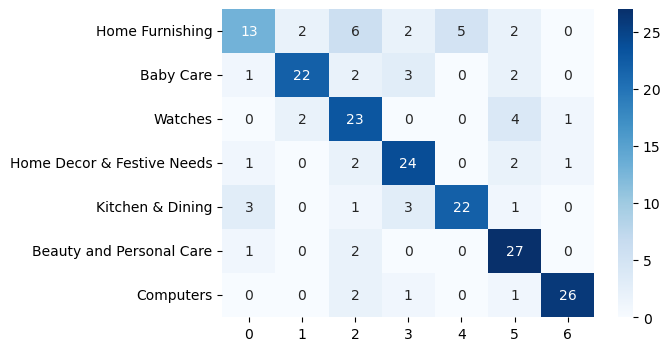

In [110]:
# Create a dataframe for the confusion matrix
df_cm = pd.DataFrame(conf_mat_transformed, index = [label for label in data['category'].unique().tolist()],
                  columns = [i for i in "0123456"])

# Plot the confusion matrix
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Approche 4 : nouvelle par Dataset avec data augmentation intégrée au modèle

In [18]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [19]:
def create_model_fct2(num_categories) :
    
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False
    
    model = Sequential([
                RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
                RandomRotation(0.1),
                RandomZoom(0.1),
#                 Rescaling(1./127.5, offset=-1),
                model0,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(num_categories, activation='softmax')
                ])
    
    loss = "categorical_crossentropy" # Mieux quand plus que 2 labels, mais sensible aux quantités de labels déséquilibrées (pas le cas ici)
    # Alternatives :
    # a) Sparse Categorical Crossentropy : Utile quand les étiquettes sont des entiers plutôt que des one-hot encodées
    # b) Binary Crossentropy :  Pour la classification binaire
    # c) Focal Loss : Pour les datasets très déséquilibrés
    
    optimizer = 'rmsprop'
    # Alternatives :
    # a) rmsprop : Bonne performance sur de nombreux problèmes, mais peut nécessiter un réglage fin du taux d'apprentissage initial
    # b) SGD (Stochastic Gradient Descent) avec momentum : donner de meilleures performances de généralisation quand on a le temps de bien ajuster les hyperparamètres
    # c) Adam : Combine les avantages de RMSprop et de SGD, souvent considéré comme un bon choix par défaut
    # d) Adagrad : Bon pour les problèmes avec des features rares (problèmes de NLP)
    
    model_metrics = [
        "accuracy", # Mesure la proportion de prédictions correctes, mais peut être trompeuse pour les datasets déséquilibrés
        # "f1-score", # Équilibre entre précision et rappel (= taux de vrais-positifs). Utile pour les datasets déséquilibrés
        # "auc-roc", # Insensible au déséquilibre des classes en classification binaire. 1 = parfait, 0.5 = pas mieux que le hasard
        # "Precision-Recall", # Donnent plus d'informations sur les types d'erreurs que fait le modèle, quand les faux positifs ou faux négatifs ont des coûts différents
    ] 
    
    model.compile(loss=loss, optimizer=optimizer, metrics=model_metrics)

    print(model.summary())
    
    return model

In [20]:
model4_save_path = "./model4_best_weights.keras"

In [21]:
# Création du modèle
with tf.device('/gpu:0'):
    model4 = create_model_fct2(num_categories)

# Création du callback
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [22]:
# with tf.device('/gpu:0'):
#     history4 = model4.fit(dataset_train,
#                         validation_data=dataset_val,
#                         batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2393 - loss: 1.9879
Epoch 1: val_loss improved from inf to 1.45518, saving model to ./model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.2407 - loss: 1.9821 - val_accuracy: 0.5905 - val_loss: 1.4552
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4486 - loss: 1.5597
Epoch 2: val_loss improved from 1.45518 to 1.29969, saving model to ./model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.4491 - loss: 1.5585 - val_accuracy: 0.6238 - val_loss: 1.2997
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4952 - loss: 1.4095
Epoch 3: val_loss improved from 1.29969 to 1.08869, saving model to ./model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.4965 - loss: 1.4072 - val_accuracy: 0.6952 - val_loss: 1.0887
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5325 - loss: 1.3133
Epoch 4: val_loss improved from 1.08

20/20 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - accuracy: 0.7512 - loss: 0.6933 - val_accuracy: 0.7381 - val_loss: 0.7367
Epoch 25/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7893 - loss: 0.6794
Epoch 25: val_loss did not improve from 0.68991
20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.7890 - loss: 0.6803 - val_accuracy: 0.7429 - val_loss: 0.7212
Epoch 26/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7491 - loss: 0.7037
Epoch 26: val_loss did not improve from 0.68991
20/20 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - accuracy: 0.7496 - loss: 0.7021 - val_accuracy: 0.7190 - val_loss: 0.7726
Epoch 27/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7987 - loss: 0.6607
Epoch 27: val_loss improved from 0.68991 to 0.68593, saving model to ./model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.7983 - loss: 0.6606 - val_accuracy: 0.7476 - val_loss: 0.6859
Epoch 28/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7811 - loss: 0.6477
Epoch 2

In [23]:
# import pickle

# # Save the trained model and history variables to a file
# with open('4-model_history.pkl', 'wb') as f:
#     pickle.dump((model4, history4), f)

In [25]:
import pickle

# Load the trained model and history variables from the file
with open('4-model_history.pkl', 'rb') as f:
    model4, history4 = pickle.load(f)

In [24]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_test, verbose=True)
print("Test Accuracy       :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.8540 - loss: 0.4534
Training Accuracy   : 0.8651

7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7838 - loss: 0.6209
Validation Accuracy :  0.7619

7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7715 - loss: 0.6650
Test Accuracy       :  0.7667


In [25]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_train, verbose=False)
print("Training Accuracy   : {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Training Accuracy   : 0.8492
Validation Accuracy :  0.7571
Test Accuracy       :  0.7857


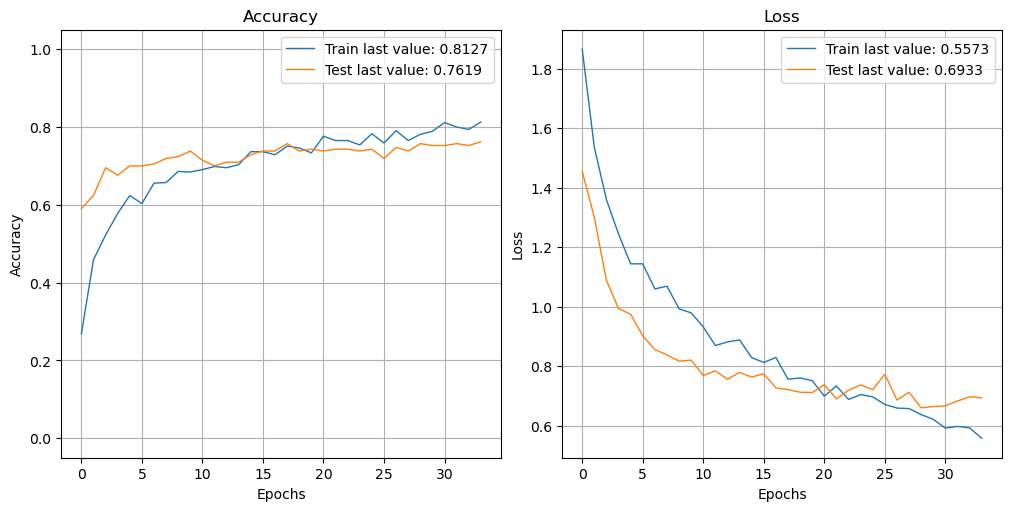

In [26]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4)
plt.close()

# Modèles de référence

## Modèle aléatoire (dummy)

In [25]:
# Define the input shape of the images
input_shape = (IMG_SIZE, IMG_SIZE, 3)

# Define the number of classes in your dataset
num_classes = len(data['category'].unique())

# Define the dummy model
model = tf.keras.Sequential([
    # Flatten the input images
    layers.Flatten(input_shape=input_shape),
    # Add a dense layer with the same number of units as the number of classes
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(dataset_val)

# Print the accuracy
print("Validation accuracy:", accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1440 - loss: 2.6228
Validation accuracy: 0.12976190447807312


Le modèle dummy est beaucoup moins moins que le modèle qu'on a créer, c'est bien.

## Regression logistique plugguée sur les features 

In [20]:
# vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# def process_image(row):
#     path = os.path.join('./Flipkart/Images', row['image'])
#     image = load_img(path, target_size=(224, 224))
#     image = img_to_array(image)
#     image = np.expand_dims(image, axis=0)
#     feature = vgg16_model.predict(image)
#     return feature.flatten()

# data['vgg16_features'] = data.apply(process_image, axis=1)

# vgg16_features = data['vgg16_features'].tolist()

In [21]:
import pickle

# Load the combined_features variable from the file
with open('vgg16_features.pkl', 'rb') as f:
    vgg16_features = pickle.load(f)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

data['vgg16_features'] = vgg16_features

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.array(data['vgg16_features'].tolist()), data['label'], test_size=0.2, random_state=18)

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model with the training data
log_reg.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = log_reg.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.63      0.68        27
           1       0.88      0.78      0.82        27
           2       0.84      0.94      0.89        33
           3       0.83      0.74      0.78        27
           4       0.74      0.93      0.83        28
           5       0.91      0.89      0.90        35
           6       1.00      1.00      1.00        33

    accuracy                           0.85       210
   macro avg       0.85      0.84      0.84       210
weighted avg       0.85      0.85      0.85       210



Le modèle de référence regression logistique sur les features est bon (accuracy = 0.85).  

Les résultats des 4 approches que j'ai réalisé sont les suivants :
- Approche classique : accuracy = 0.8905
- Approche classique avec data augmentation : accuracy = 0.8905
- Approche par data set : accuracy = 0.7476
- Approche par data set avec data augmentation : accuracy = 0.7857

Tous les modèles que j'ai créé surpassent le modèle de regression logistique.  
Le meilleur modèle est celui avec l'approche classique et sans data augmentation.

# Notes